# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_3.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_2.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_1.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/test_image_data_0.parquet
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/sample_submission.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/class_map.csv
/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/train_image_data_3.parquet


In [4]:
import torch

debug=False
submission=False
batch_size=64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size=128
arch='pretrained'
model_name='se_resnext101_32x4d'
TH = 20

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('seresnext101_1e-4_aug_bs64')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [115]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

# def crop_resize(img0, size=image_size, thh = 80, thl = 28, pad=3):
#     #crop a box around pixels large than the threshold 
#     #some images contain line at the sides
#     ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
#     #cropping may cut too much, so we need to add it back
#     xmin = xmin - 13 if (xmin > 13) else 0
#     ymin = ymin - 10 if (ymin > 10) else 0
#     xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#     ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#     img = img0[ymin:ymax,xmin:xmax]
#     #remove lo intensity pixels as noise
#     img[img < thl] = 0
#     lx, ly = xmax-xmin,ymax-ymin
#     l = max(lx,ly) + pad
#     #make sure that the aspect ratio is kept in rescaling
#     img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
#     return cv2.resize(img,(size,size))

def crop_resize(img0, size=image_size, thh = 80, thl = 28, pad=3):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 5 if (xmin > 5) else 0
    ymin = ymin - 5 if (ymin > 5) else 0
    xmax = xmax + 5 if (xmax < WIDTH - 5) else WIDTH
    ymax = ymax + 5 if (ymax < HEIGHT - 5) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 44 s, sys: 38.4 s, total: 1min 22s
Wall time: 7.95 s


In [10]:
#  import sys 

# # These are the usual ipython objects, including this one you are creating 
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# # Get a sorted list of the objects and their sizes 
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

<a id="dataset"></a>
# Dataset

In [11]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [12]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [13]:
train_dataset_noaug = BengaliAIDataset(train_images, train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [14]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [15]:
# print(image[:5,:5])
# print(20/255)


30it [00:00, 695.97it/s]


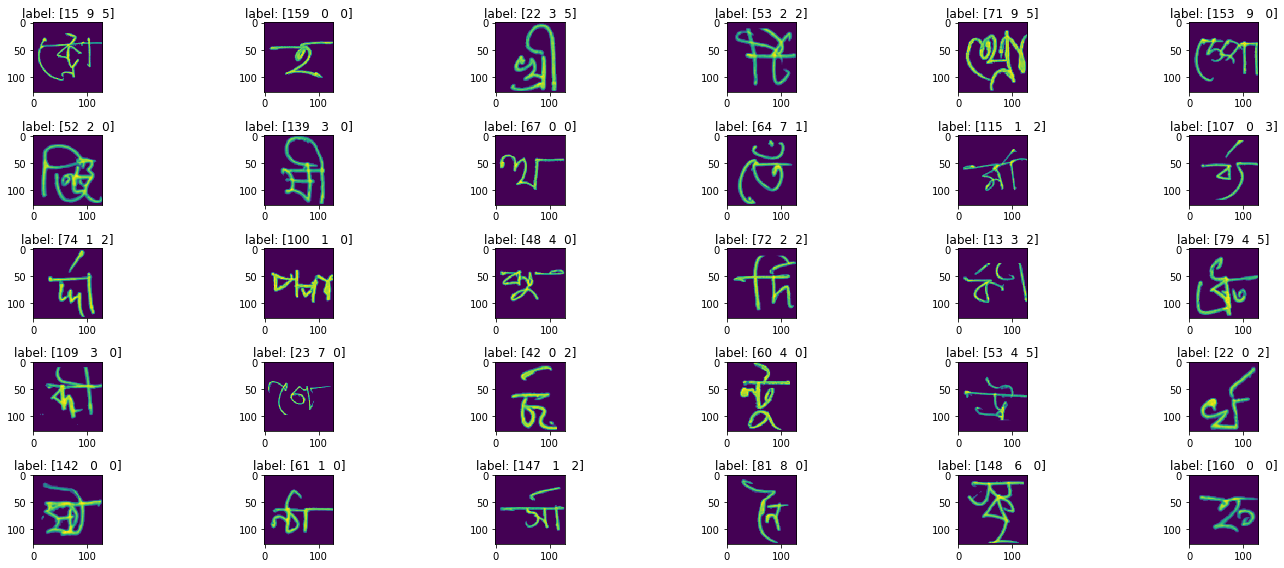

<Figure size 432x288 with 0 Axes>

In [116]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = TH/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [119]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.85
    max_scale = 1.15
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
    print("rot:{}, shear:{},tx:{},ty:{},sx:{}, sy:{}".format(rot_angle,shear_angle, tx,ty, sx, sy))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear


18it [00:00, 382.59it/s]


rot:0.03634855603760602, shear:0.018179037248024124,tx:0,ty:-2,sx:0.9542509517625355, sy:1.053809042248218
rot:-0.04653022283892471, shear:0.12638594664125524,tx:0,ty:-3,sx:0.983331892784189, sy:1.0937879473335625
rot:0.007033468399158681, shear:0.013043719034149926,tx:-2,ty:0,sx:1.0387583401909113, sy:1.059907028798948
rot:-0.09702260029799974, shear:-0.01198692957601876,tx:2,ty:-1,sx:1.1321391582881124, sy:1.1126522205195544
rot:0.1034634854491594, shear:-0.010527172236551275,tx:-2,ty:-3,sx:0.9817684636331374, sy:0.96155156848122
rot:0.0010789744649331524, shear:-0.01948833168437663,tx:2,ty:2,sx:1.088695099223715, sy:1.0832541796840136
rot:0.01738948464619749, shear:-0.16978974959831852,tx:3,ty:-4,sx:1.1100550896200154, sy:1.0806072472028168
rot:0.05136936544850646, shear:-0.16721145606743615,tx:1,ty:-1,sx:0.9680737081036692, sy:1.0911583405184544
rot:-0.10488737510620603, shear:-0.14006254430537116,tx:-2,ty:1,sx:0.9263273109029, sy:0.8925507511494057
rot:0.08282429693025965, shear:0

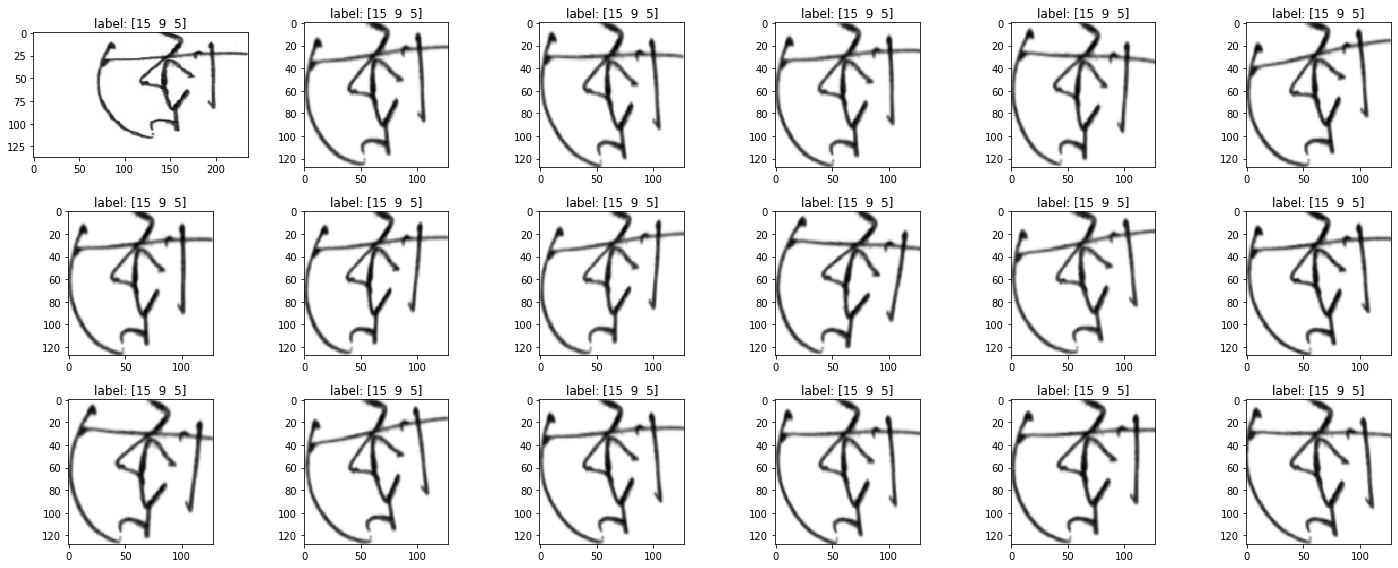

In [123]:
nrow, ncol = 3, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[0]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = TH/255, thl=28.0/255, pad=2)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

SyntaxError: invalid syntax (<ipython-input-124-f6a8b0339fbd>, line 10)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image


30it [00:00, 718.44it/s]


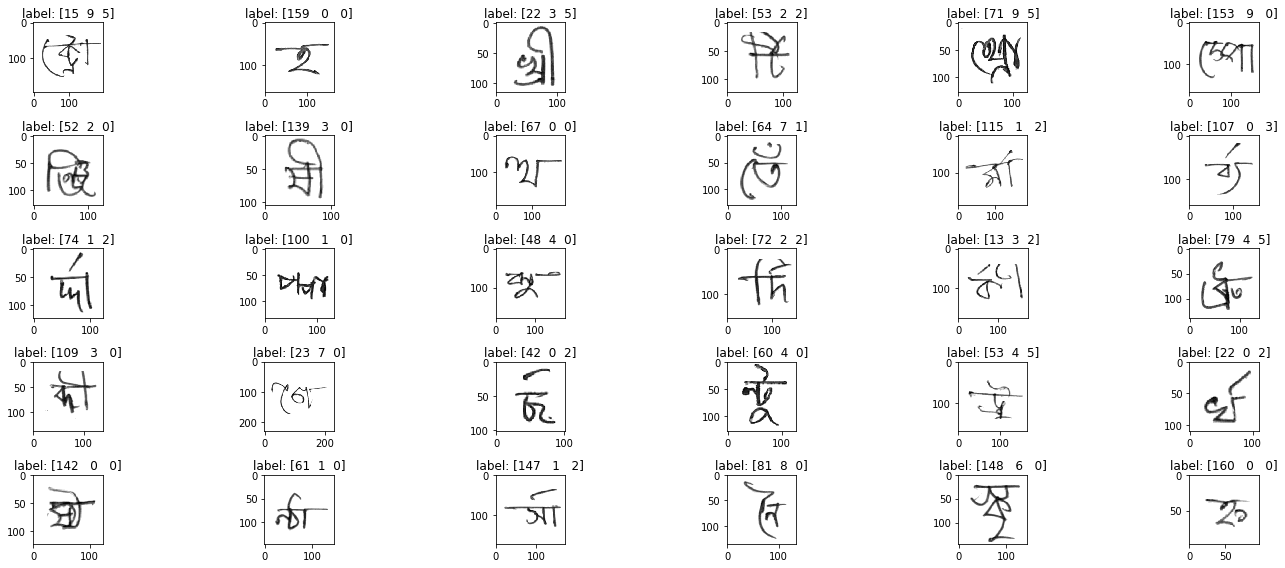

In [125]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=TH/255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

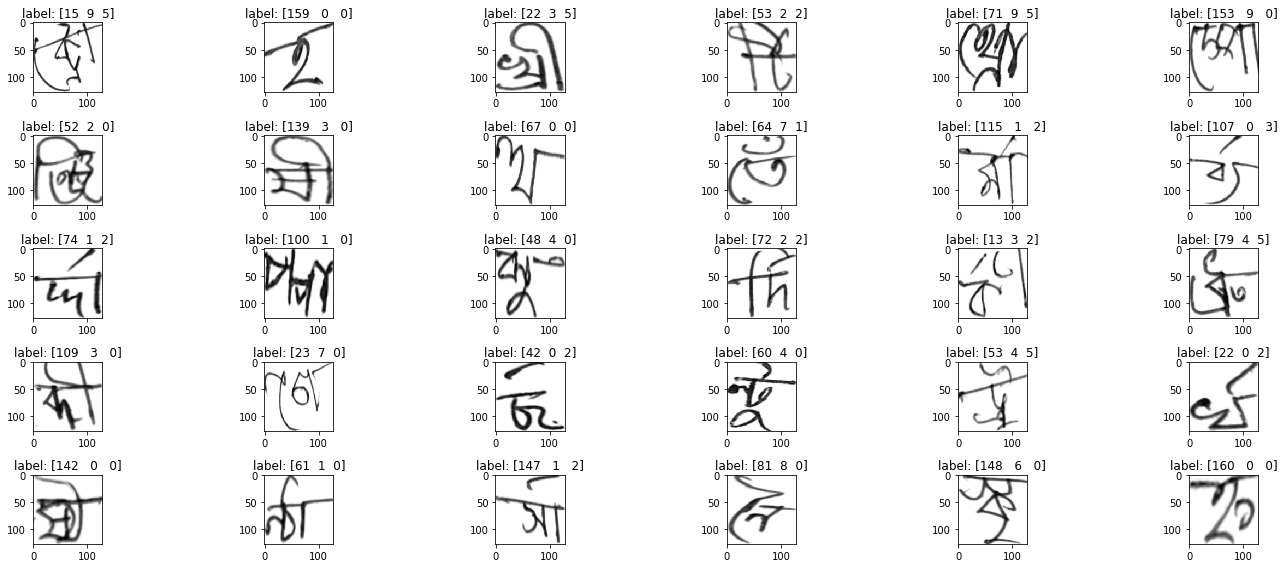

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=TH/255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [21]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=3, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [22]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

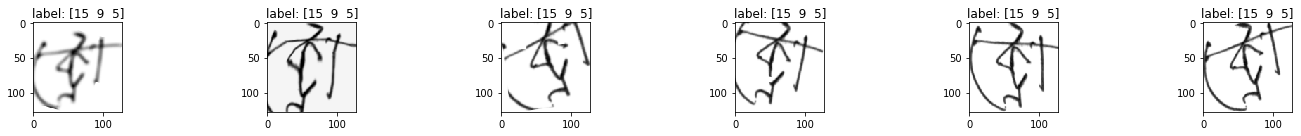

In [23]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

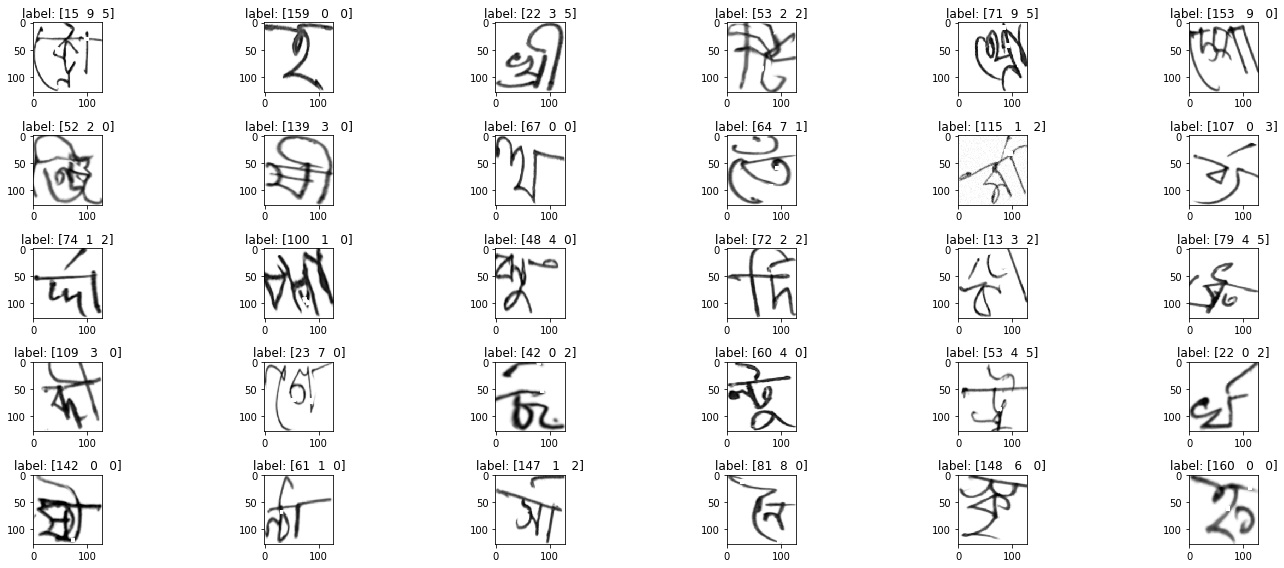

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
a = np.array([2,3])
b = np.array([4,5,6])

In [29]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [30]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [31]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [32]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False, dropout_ratio = 0.1)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False, dropout_ratio = 0.1)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [34]:
import CLR as CLR
import OneCycle as OneCycle

In [35]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [36]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [37]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

# --- Training setting ---

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [38]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [39]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        elem['mode'] = mode
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [40]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [41]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [42]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [43]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [44]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [45]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [46]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint != None:
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(checkpoint['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [47]:
def save_params(outdir, k, img_size, th, arch, model_name):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'arch': arch, 
               'model_name': model_name}
             )

In [48]:
import gc

n_epochs = 140
kfold = 2

if not os.path.exists(outdir):
    os.mkdir(outdir)

for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained='imagenet')
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.0001, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch, model_name)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/2511 [00:00<?, ?it/s]/home/chen/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      0 train/loss  3.120022 train/loss_grapheme  1.964027 train/loss_vowel  0.615271 train/loss_consonant  0.540723 train/acc_grapheme  0.627788 train/acc_vowel  0.843968 train/acc_consonant  0.900922 train/recall  0.641707 val/loss  0.853582 val/loss_grapheme  0.509338 val/loss_vowel  0.182760 val/loss_consonant  0.161485 val/acc_grapheme  0.889962 val/acc_vowel  0.960391 val/acc_consonant  0.961860 val/recall  0.882166 lr  0.001000 elapsed_time  2052.421592 mode 011 


100%|██████████| 628/628 [02:51<00:00,  3.67it/s]


epoch      1 train/loss  1.694100 train/loss_grapheme  1.117531 train/loss_vowel  0.332491 train/loss_consonant  0.244078 train/acc_grapheme  0.783584 train/acc_vowel  0.900991 train/acc_consonant  0.944128 train/recall  0.775850 val/loss  0.574319 val/loss_grapheme  0.360434 val/loss_vowel  0.108128 val/loss_consonant  0.105757 val/acc_grapheme  0.916326 val/acc_vowel  0.975453 val/acc_consonant  0.971345 val/recall  0.914459 lr  0.001000 elapsed_time  4107.835745 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      2 train/loss  1.461113 train/loss_grapheme  0.985691 train/loss_vowel  0.272873 train/loss_consonant  0.202549 train/acc_grapheme  0.803917 train/acc_vowel  0.917889 train/acc_consonant  0.950041 train/recall  0.797209 val/loss  0.521388 val/loss_grapheme  0.350502 val/loss_vowel  0.089212 val/loss_consonant  0.081674 val/acc_grapheme  0.921355 val/acc_vowel  0.977893 val/acc_consonant  0.976723 val/recall  0.916985 lr  0.001000 elapsed_time  6151.446201 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      3 train/loss  1.350028 train/loss_grapheme  0.925644 train/loss_vowel  0.241853 train/loss_consonant  0.182530 train/acc_grapheme  0.812712 train/acc_vowel  0.924517 train/acc_consonant  0.954709 train/recall  0.807784 val/loss  0.462257 val/loss_grapheme  0.297338 val/loss_vowel  0.084951 val/loss_consonant  0.079968 val/acc_grapheme  0.933878 val/acc_vowel  0.978889 val/acc_consonant  0.978490 val/recall  0.928727 lr  0.001000 elapsed_time  8184.662557 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      4 train/loss  1.264617 train/loss_grapheme  0.867125 train/loss_vowel  0.227260 train/loss_consonant  0.170232 train/acc_grapheme  0.820603 train/acc_vowel  0.928780 train/acc_consonant  0.957790 train/recall  0.814999 val/loss  0.464997 val/loss_grapheme  0.302811 val/loss_vowel  0.084869 val/loss_consonant  0.077317 val/acc_grapheme  0.930965 val/acc_vowel  0.977743 val/acc_consonant  0.978640 val/recall  0.925845 lr  0.001000 elapsed_time  10215.545784 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      5 train/loss  1.213670 train/loss_grapheme  0.837098 train/loss_vowel  0.213736 train/loss_consonant  0.162836 train/acc_grapheme  0.824705 train/acc_vowel  0.931233 train/acc_consonant  0.959171 train/recall  0.819799 val/loss  0.415960 val/loss_grapheme  0.272987 val/loss_vowel  0.073270 val/loss_consonant  0.069703 val/acc_grapheme  0.936666 val/acc_vowel  0.981752 val/acc_consonant  0.980582 val/recall  0.932569 lr  0.001000 elapsed_time  12245.215142 mode 011 


100%|██████████| 628/628 [02:49<00:00,  3.71it/s]


epoch      6 train/loss  1.175627 train/loss_grapheme  0.812449 train/loss_vowel  0.205771 train/loss_consonant  0.157407 train/acc_grapheme  0.825993 train/acc_vowel  0.932975 train/acc_consonant  0.960597 train/recall  0.820739 val/loss  0.423020 val/loss_grapheme  0.278082 val/loss_vowel  0.072601 val/loss_consonant  0.072338 val/acc_grapheme  0.935222 val/acc_vowel  0.982623 val/acc_consonant  0.979362 val/recall  0.931135 lr  0.001000 elapsed_time  14258.979763 mode 000 


100%|██████████| 628/628 [02:49<00:00,  3.70it/s]


epoch      7 train/loss  1.150922 train/loss_grapheme  0.795301 train/loss_vowel  0.201490 train/loss_consonant  0.154131 train/acc_grapheme  0.828352 train/acc_vowel  0.933784 train/acc_consonant  0.960510 train/recall  0.821419 val/loss  0.409337 val/loss_grapheme  0.270676 val/loss_vowel  0.072241 val/loss_consonant  0.066420 val/acc_grapheme  0.935844 val/acc_vowel  0.981528 val/acc_consonant  0.982075 val/recall  0.932879 lr  0.001000 elapsed_time  16264.589843 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      8 train/loss  1.114115 train/loss_grapheme  0.768708 train/loss_vowel  0.195553 train/loss_consonant  0.149854 train/acc_grapheme  0.831589 train/acc_vowel  0.934979 train/acc_consonant  0.961885 train/recall  0.826379 val/loss  0.389739 val/loss_grapheme  0.251258 val/loss_vowel  0.067069 val/loss_consonant  0.071411 val/acc_grapheme  0.941645 val/acc_vowel  0.983768 val/acc_consonant  0.980582 val/recall  0.936437 lr  0.001000 elapsed_time  18266.739677 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch      9 train/loss  1.096428 train/loss_grapheme  0.755984 train/loss_vowel  0.193073 train/loss_consonant  0.147371 train/acc_grapheme  0.832441 train/acc_vowel  0.936062 train/acc_consonant  0.962707 train/recall  0.826842 val/loss  0.379640 val/loss_grapheme  0.247008 val/loss_vowel  0.068162 val/loss_consonant  0.064470 val/acc_grapheme  0.941321 val/acc_vowel  0.983743 val/acc_consonant  0.982125 val/recall  0.938273 lr  0.001000 elapsed_time  20260.560757 mode 111 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     10 train/loss  1.088073 train/loss_grapheme  0.750962 train/loss_vowel  0.190471 train/loss_consonant  0.146641 train/acc_grapheme  0.832883 train/acc_vowel  0.935919 train/acc_consonant  0.963211 train/recall  0.826995 val/loss  0.385803 val/loss_grapheme  0.250615 val/loss_vowel  0.068768 val/loss_consonant  0.066421 val/acc_grapheme  0.943189 val/acc_vowel  0.983171 val/acc_consonant  0.982150 val/recall  0.939630 lr  0.001000 elapsed_time  22247.520701 mode 001 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     11 train/loss  1.082950 train/loss_grapheme  0.747460 train/loss_vowel  0.189997 train/loss_consonant  0.145493 train/acc_grapheme  0.832721 train/acc_vowel  0.936417 train/acc_consonant  0.963584 train/recall  0.827804 val/loss  0.382693 val/loss_grapheme  0.245274 val/loss_vowel  0.070463 val/loss_consonant  0.066956 val/acc_grapheme  0.941272 val/acc_vowel  0.983569 val/acc_consonant  0.981826 val/recall  0.937102 lr  0.001000 elapsed_time  24241.889621 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     12 train/loss  1.062258 train/loss_grapheme  0.733800 train/loss_vowel  0.185718 train/loss_consonant  0.142741 train/acc_grapheme  0.834532 train/acc_vowel  0.937270 train/acc_consonant  0.964113 train/recall  0.829266 val/loss  0.401059 val/loss_grapheme  0.253281 val/loss_vowel  0.075784 val/loss_consonant  0.071994 val/acc_grapheme  0.940002 val/acc_vowel  0.981328 val/acc_consonant  0.980382 val/recall  0.933398 lr  0.001000 elapsed_time  26248.432483 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     13 train/loss  1.057346 train/loss_grapheme  0.727122 train/loss_vowel  0.185799 train/loss_consonant  0.144425 train/acc_grapheme  0.835391 train/acc_vowel  0.936871 train/acc_consonant  0.963566 train/recall  0.828552 val/loss  0.374421 val/loss_grapheme  0.241977 val/loss_vowel  0.066362 val/loss_consonant  0.066082 val/acc_grapheme  0.942790 val/acc_vowel  0.983743 val/acc_consonant  0.981353 val/recall  0.939862 lr  0.001000 elapsed_time  28264.031504 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     14 train/loss  1.041757 train/loss_grapheme  0.718885 train/loss_vowel  0.182414 train/loss_consonant  0.140458 train/acc_grapheme  0.835783 train/acc_vowel  0.937102 train/acc_consonant  0.965234 train/recall  0.830892 val/loss  0.394266 val/loss_grapheme  0.262237 val/loss_vowel  0.062848 val/loss_consonant  0.069181 val/acc_grapheme  0.937089 val/acc_vowel  0.984664 val/acc_consonant  0.981652 val/recall  0.934611 lr  0.001000 elapsed_time  30274.943021 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     15 train/loss  1.039098 train/loss_grapheme  0.719064 train/loss_vowel  0.179839 train/loss_consonant  0.140195 train/acc_grapheme  0.836095 train/acc_vowel  0.938409 train/acc_consonant  0.965327 train/recall  0.830574 val/loss  0.393527 val/loss_grapheme  0.262003 val/loss_vowel  0.067290 val/loss_consonant  0.064233 val/acc_grapheme  0.939056 val/acc_vowel  0.983693 val/acc_consonant  0.983121 val/recall  0.937253 lr  0.001000 elapsed_time  32280.076832 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     16 train/loss  1.024602 train/loss_grapheme  0.709356 train/loss_vowel  0.178747 train/loss_consonant  0.136499 train/acc_grapheme  0.837489 train/acc_vowel  0.938185 train/acc_consonant  0.966260 train/recall  0.832712 val/loss  0.395782 val/loss_grapheme  0.258695 val/loss_vowel  0.069604 val/loss_consonant  0.067483 val/acc_grapheme  0.938309 val/acc_vowel  0.982698 val/acc_consonant  0.981777 val/recall  0.935042 lr  0.001000 elapsed_time  34291.141316 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     17 train/loss  1.022366 train/loss_grapheme  0.707014 train/loss_vowel  0.177844 train/loss_consonant  0.137508 train/acc_grapheme  0.838043 train/acc_vowel  0.938614 train/acc_consonant  0.965470 train/recall  0.832801 val/loss  0.361897 val/loss_grapheme  0.235764 val/loss_vowel  0.063514 val/loss_consonant  0.062619 val/acc_grapheme  0.944085 val/acc_vowel  0.984814 val/acc_consonant  0.983569 val/recall  0.941009 lr  0.001000 elapsed_time  36296.182846 mode 011 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     18 train/loss  1.020095 train/loss_grapheme  0.707683 train/loss_vowel  0.175388 train/loss_consonant  0.137024 train/acc_grapheme  0.837140 train/acc_vowel  0.939093 train/acc_consonant  0.965899 train/recall  0.832243 val/loss  0.376468 val/loss_grapheme  0.242999 val/loss_vowel  0.068484 val/loss_consonant  0.064985 val/acc_grapheme  0.942716 val/acc_vowel  0.984216 val/acc_consonant  0.982225 val/recall  0.939648 lr  0.001000 elapsed_time  38293.129716 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     19 train/loss  1.010557 train/loss_grapheme  0.700045 train/loss_vowel  0.176276 train/loss_consonant  0.134236 train/acc_grapheme  0.838373 train/acc_vowel  0.938938 train/acc_consonant  0.965899 train/recall  0.831770 val/loss  0.388981 val/loss_grapheme  0.246057 val/loss_vowel  0.073116 val/loss_consonant  0.069808 val/acc_grapheme  0.942865 val/acc_vowel  0.982374 val/acc_consonant  0.981129 val/recall  0.937417 lr  0.001000 elapsed_time  40297.670055 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     20 train/loss  1.013319 train/loss_grapheme  0.702355 train/loss_vowel  0.176578 train/loss_consonant  0.134387 train/acc_grapheme  0.838167 train/acc_vowel  0.939050 train/acc_consonant  0.966036 train/recall  0.832194 val/loss  0.379185 val/loss_grapheme  0.244545 val/loss_vowel  0.069347 val/loss_consonant  0.065293 val/acc_grapheme  0.942915 val/acc_vowel  0.983096 val/acc_consonant  0.981702 val/recall  0.937487 lr  0.001000 elapsed_time  42293.233790 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     21 train/loss  1.003120 train/loss_grapheme  0.695023 train/loss_vowel  0.174291 train/loss_consonant  0.133806 train/acc_grapheme  0.839107 train/acc_vowel  0.939373 train/acc_consonant  0.966665 train/recall  0.834501 val/loss  0.388775 val/loss_grapheme  0.249678 val/loss_vowel  0.068756 val/loss_consonant  0.070341 val/acc_grapheme  0.940824 val/acc_vowel  0.983469 val/acc_consonant  0.980507 val/recall  0.937757 lr  0.001000 elapsed_time  44286.878701 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     22 train/loss  0.995088 train/loss_grapheme  0.687573 train/loss_vowel  0.174311 train/loss_consonant  0.133204 train/acc_grapheme  0.840159 train/acc_vowel  0.939019 train/acc_consonant  0.966242 train/recall  0.833736 val/loss  0.375336 val/loss_grapheme  0.248405 val/loss_vowel  0.064544 val/loss_consonant  0.062387 val/acc_grapheme  0.941122 val/acc_vowel  0.983918 val/acc_consonant  0.982922 val/recall  0.938608 lr  0.001000 elapsed_time  46283.347573 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     23 train/loss  0.996365 train/loss_grapheme  0.691957 train/loss_vowel  0.172171 train/loss_consonant  0.132238 train/acc_grapheme  0.839848 train/acc_vowel  0.940375 train/acc_consonant  0.966920 train/recall  0.835344 val/loss  0.368826 val/loss_grapheme  0.240223 val/loss_vowel  0.065722 val/loss_consonant  0.062881 val/acc_grapheme  0.944533 val/acc_vowel  0.984042 val/acc_consonant  0.983420 val/recall  0.940914 lr  0.001000 elapsed_time  48297.690733 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     24 train/loss  0.991547 train/loss_grapheme  0.686179 train/loss_vowel  0.173135 train/loss_consonant  0.132234 train/acc_grapheme  0.841092 train/acc_vowel  0.939168 train/acc_consonant  0.966404 train/recall  0.835484 val/loss  0.369010 val/loss_grapheme  0.238425 val/loss_vowel  0.067537 val/loss_consonant  0.063048 val/acc_grapheme  0.944209 val/acc_vowel  0.983295 val/acc_consonant  0.982822 val/recall  0.940430 lr  0.001000 elapsed_time  50311.256034 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     25 train/loss  0.992722 train/loss_grapheme  0.690928 train/loss_vowel  0.171053 train/loss_consonant  0.130740 train/acc_grapheme  0.839368 train/acc_vowel  0.940519 train/acc_consonant  0.966752 train/recall  0.834988 val/loss  0.351695 val/loss_grapheme  0.230915 val/loss_vowel  0.061348 val/loss_consonant  0.059433 val/acc_grapheme  0.945454 val/acc_vowel  0.985162 val/acc_consonant  0.984366 val/recall  0.942935 lr  0.001000 elapsed_time  52306.001252 mode 011 


100%|██████████| 628/628 [02:49<00:00,  3.70it/s]


epoch     26 train/loss  0.976923 train/loss_grapheme  0.678336 train/loss_vowel  0.169033 train/loss_consonant  0.129554 train/acc_grapheme  0.842337 train/acc_vowel  0.940562 train/acc_consonant  0.967599 train/recall  0.837408 val/loss  0.373010 val/loss_grapheme  0.240499 val/loss_vowel  0.069691 val/loss_consonant  0.062821 val/acc_grapheme  0.941521 val/acc_vowel  0.982972 val/acc_consonant  0.984167 val/recall  0.940059 lr  0.001000 elapsed_time  54310.315963 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     27 train/loss  0.976178 train/loss_grapheme  0.674190 train/loss_vowel  0.171005 train/loss_consonant  0.130983 train/acc_grapheme  0.843202 train/acc_vowel  0.939641 train/acc_consonant  0.966958 train/recall  0.836580 val/loss  0.350833 val/loss_grapheme  0.227776 val/loss_vowel  0.062205 val/loss_consonant  0.060852 val/acc_grapheme  0.946226 val/acc_vowel  0.984142 val/acc_consonant  0.983918 val/recall  0.942822 lr  0.001000 elapsed_time  56316.368407 mode 010 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     28 train/loss  0.975017 train/loss_grapheme  0.677677 train/loss_vowel  0.169445 train/loss_consonant  0.127894 train/acc_grapheme  0.842306 train/acc_vowel  0.940419 train/acc_consonant  0.967599 train/recall  0.836866 val/loss  0.370417 val/loss_grapheme  0.238808 val/loss_vowel  0.062408 val/loss_consonant  0.069200 val/acc_grapheme  0.943214 val/acc_vowel  0.985038 val/acc_consonant  0.981005 val/recall  0.938294 lr  0.001000 elapsed_time  58313.844830 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     29 train/loss  0.981417 train/loss_grapheme  0.682647 train/loss_vowel  0.169365 train/loss_consonant  0.129405 train/acc_grapheme  0.841105 train/acc_vowel  0.940357 train/acc_consonant  0.968177 train/recall  0.837037 val/loss  0.367035 val/loss_grapheme  0.236822 val/loss_vowel  0.064733 val/loss_consonant  0.065479 val/acc_grapheme  0.944085 val/acc_vowel  0.984117 val/acc_consonant  0.983270 val/recall  0.940313 lr  0.001000 elapsed_time  60315.204169 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     30 train/loss  0.972630 train/loss_grapheme  0.674708 train/loss_vowel  0.168555 train/loss_consonant  0.129367 train/acc_grapheme  0.842518 train/acc_vowel  0.940886 train/acc_consonant  0.967704 train/recall  0.837252 val/loss  0.368627 val/loss_grapheme  0.242196 val/loss_vowel  0.062270 val/loss_consonant  0.064161 val/acc_grapheme  0.944433 val/acc_vowel  0.984739 val/acc_consonant  0.983096 val/recall  0.941663 lr  0.001000 elapsed_time  62303.933039 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     31 train/loss  0.979878 train/loss_grapheme  0.681427 train/loss_vowel  0.167691 train/loss_consonant  0.130760 train/acc_grapheme  0.841366 train/acc_vowel  0.940755 train/acc_consonant  0.967455 train/recall  0.835565 val/loss  0.375260 val/loss_grapheme  0.237692 val/loss_vowel  0.071542 val/loss_consonant  0.066025 val/acc_grapheme  0.944184 val/acc_vowel  0.983046 val/acc_consonant  0.982200 val/recall  0.941025 lr  0.001000 elapsed_time  64308.886768 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     32 train/loss  0.970384 train/loss_grapheme  0.672632 train/loss_vowel  0.167652 train/loss_consonant  0.130101 train/acc_grapheme  0.842941 train/acc_vowel  0.941241 train/acc_consonant  0.967256 train/recall  0.838061 val/loss  0.367930 val/loss_grapheme  0.236391 val/loss_vowel  0.066813 val/loss_consonant  0.064726 val/acc_grapheme  0.945305 val/acc_vowel  0.984341 val/acc_consonant  0.982349 val/recall  0.942245 lr  0.001000 elapsed_time  66314.631582 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     33 train/loss  0.972627 train/loss_grapheme  0.678048 train/loss_vowel  0.165702 train/loss_consonant  0.128877 train/acc_grapheme  0.841740 train/acc_vowel  0.941620 train/acc_consonant  0.967655 train/recall  0.837409 val/loss  0.431215 val/loss_grapheme  0.273164 val/loss_vowel  0.084476 val/loss_consonant  0.073574 val/acc_grapheme  0.935844 val/acc_vowel  0.977171 val/acc_consonant  0.979959 val/recall  0.931935 lr  0.001000 elapsed_time  68322.076290 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     34 train/loss  0.974357 train/loss_grapheme  0.678961 train/loss_vowel  0.166590 train/loss_consonant  0.128806 train/acc_grapheme  0.842188 train/acc_vowel  0.941048 train/acc_consonant  0.967412 train/recall  0.836399 val/loss  0.366370 val/loss_grapheme  0.237960 val/loss_vowel  0.065098 val/loss_consonant  0.063312 val/acc_grapheme  0.945404 val/acc_vowel  0.984739 val/acc_consonant  0.982474 val/recall  0.940780 lr  0.001000 elapsed_time  70328.524175 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     35 train/loss  0.970923 train/loss_grapheme  0.678699 train/loss_vowel  0.165339 train/loss_consonant  0.126884 train/acc_grapheme  0.841877 train/acc_vowel  0.940761 train/acc_consonant  0.968209 train/recall  0.837174 val/loss  0.384557 val/loss_grapheme  0.248900 val/loss_vowel  0.072885 val/loss_consonant  0.062772 val/acc_grapheme  0.940500 val/acc_vowel  0.981254 val/acc_consonant  0.983096 val/recall  0.937867 lr  0.001000 elapsed_time  72337.327715 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     36 train/loss  0.963647 train/loss_grapheme  0.671571 train/loss_vowel  0.164220 train/loss_consonant  0.127856 train/acc_grapheme  0.843047 train/acc_vowel  0.940083 train/acc_consonant  0.968377 train/recall  0.837976 val/loss  0.351178 val/loss_grapheme  0.227646 val/loss_vowel  0.065153 val/loss_consonant  0.058379 val/acc_grapheme  0.945205 val/acc_vowel  0.984341 val/acc_consonant  0.984266 val/recall  0.941140 lr  0.001000 elapsed_time  74351.686416 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     37 train/loss  0.974155 train/loss_grapheme  0.681299 train/loss_vowel  0.164480 train/loss_consonant  0.128376 train/acc_grapheme  0.841242 train/acc_vowel  0.941290 train/acc_consonant  0.966709 train/recall  0.836381 val/loss  0.367501 val/loss_grapheme  0.242733 val/loss_vowel  0.063977 val/loss_consonant  0.060790 val/acc_grapheme  0.942467 val/acc_vowel  0.984640 val/acc_consonant  0.983942 val/recall  0.939695 lr  0.001000 elapsed_time  76373.386486 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     38 train/loss  0.961408 train/loss_grapheme  0.668981 train/loss_vowel  0.165028 train/loss_consonant  0.127400 train/acc_grapheme  0.843930 train/acc_vowel  0.940487 train/acc_consonant  0.968072 train/recall  0.838454 val/loss  0.378249 val/loss_grapheme  0.245596 val/loss_vowel  0.067330 val/loss_consonant  0.065323 val/acc_grapheme  0.941720 val/acc_vowel  0.984341 val/acc_consonant  0.982449 val/recall  0.939175 lr  0.001000 elapsed_time  78384.609048 mode 000 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     39 train/loss  0.968679 train/loss_grapheme  0.677290 train/loss_vowel  0.162282 train/loss_consonant  0.129107 train/acc_grapheme  0.842113 train/acc_vowel  0.941987 train/acc_consonant  0.967518 train/recall  0.838052 val/loss  0.372785 val/loss_grapheme  0.238923 val/loss_vowel  0.065700 val/loss_consonant  0.068162 val/acc_grapheme  0.943662 val/acc_vowel  0.984266 val/acc_consonant  0.981229 val/recall  0.940281 lr  0.001000 elapsed_time  80394.454987 mode 100 


  0%|          | 0/2511 [00:00<?, ?it/s]

epoch     40 train/loss  0.968570 train/loss_grapheme  0.678054 train/loss_vowel  0.163394 train/loss_consonant  0.127123 train/acc_grapheme  0.841180 train/acc_vowel  0.942479 train/acc_consonant  0.967524 train/recall  0.837235 val/loss  0.381994 val/loss_grapheme  0.251888 val/loss_vowel  0.065691 val/loss_consonant  0.064416 val/acc_grapheme  0.942218 val/acc_vowel  0.984092 val/acc_consonant  0.982449 val/recall  0.938483 lr  0.001000 elapsed_time  82411.555705 mode 000 


 80%|████████  | 2010/2511 [24:28<06:03,  1.38it/s]

KeyboardInterrupt: 

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>

In [ ]:
model_file_name = outdir / 'predictor_{}_{}.pt'.format(0,epoch)
torch.save(predictor.state_dict(), model_file_name)